
# ML model to support approve/deny decision for credit card loan

#### sensitive variable: gender (other examples are race, and ethnicity)
#### fairness metrics: demographic parity, equal opportunity, and equal accuracy 

References:
- https://www.kaggle.com/code/alexisbcook/exercise-ai-fairness


# import

In [358]:
import pandas as pd
import numpy as np
import mlflow
import logging
import joblib, datetime, os, time, yaml
from os import environ as env
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import json

# configure

In [359]:
# harness
'''
Harness CI Runner can automatically change values for some variable
For example is_local_development to False and tree_method to hist
'''
is_local_development = True 
notebook_dir = 'notebooks'
config_file_path = 'config.yml'
model_name = 'dt'

In [360]:
# set working dir
original_cwd = os.getcwd()

if not is_local_development:
    
    os.chdir(notebook_dir)
    os.getcwd()
    
print(os.getcwd())

/Users/jtitra/Desktop/ml-ops/ml-ops


In [361]:
# Set logging
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()

In [362]:
# set parameters
with open(config_file_path, "r") as file:
    config = yaml.safe_load(file)

# set model related parameters
data_file_path = config['data']['load_file_path']
selected_model_file_path = config['model']['save_file_path']
selected_model_metrics_file_path = config['model']['save_metrics_file_path']

# set MLFlow related parameters
experiment_name = config["mlflow"]["experiment_name"]
tracking_uri = config["mlflow"]["tracking_uri"]
run_name = config["mlflow"]["run_name"]

# experiment

In [363]:
# load data

data = pd.read_csv(data_file_path)
X = data.drop(["Target"], axis=1)
y = data["Target"]

# train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

print("Data successfully loaded!\n")
X_train.head()

Data successfully loaded!



,Num_Children,Group,Income,Own_Car,Own_Housing
491916,3,0,66191,0,0
16206,1,0,41549,1,0
42818,3,0,49118,1,1
115110,0,0,90408,1,0
401620,1,1,68250,1,0


In [364]:
# Confusion matrix with saving plot functionality
def get_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                         include_values=True, xticks_rotation='horizontal', values_format='',
                         normalize=None, cmap=plt.cm.Blues, file_prefix=''):
    matrix = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=display_labels)
    disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation, values_format=values_format)
    plt.savefig(f"outputs/{file_prefix}confusion_matrix.jpg",  bbox_inches='tight')  # Save plot as JPEG file
    return matrix, disp

# Fairness stats with saving plot functionality
def get_fairness_stats(X, y, model, group_one, preds):
    fairness_stats = {}
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    # Overall confusion matrix
    cm, disp = get_confusion_matrix(model, X, y, preds, file_prefix='overall_')
    disp.ax_.set_title("Overall")
    
    # Group 0 confusion matrix
    cm_zero, disp_zero = get_confusion_matrix(model, X_zero, y_zero, preds_zero, file_prefix='group_0_')
    disp_zero.ax_.set_title("Group 0")
    
    # Group 1 confusion matrix
    cm_one, disp_one = get_confusion_matrix(model, X_one, y_one, preds_one, file_prefix='group_1_')
    disp_one.ax_.set_title("Group 1")
    
    fairness_stats['demographic_parity'] = {'total_number_of_approvals': preds.sum(), 
                                            'group_0_%': round(preds_zero.sum()/sum(preds)*100, 2),
                                            'group_1_%': round(preds_one.sum()/sum(preds)*100, 2)}         
    fairness_stats['equal_opportunity'] = {'true_positive_rate': round(cm[1,1] / cm[1].sum()*100, 2),
                                           'group_0_%': round(cm_zero[1,1] / cm_zero[1].sum()*100, 2),
                                           'group_1_%': round(cm_one[1,1] / cm_one[1].sum()*100, 2)}
    fairness_stats['equal_accuracy'] = {'overall_accuracy': round((preds==y).sum()/len(y)*100, 2),
                                        'group_0_%': round((preds_zero==y_zero).sum()/len(y_zero)*100, 2),
                                        'group_1_%': round((preds_one==y_one).sum()/len(y_one)*100, 2)}
    fairness_stats['confusion_matrix'] = {'overall_confusion_matrix': cm.tolist(), 
                                          'group_0': cm_zero.tolist(),
                                          'group_1': cm_one.tolist()}
    return fairness_stats

# General metrics function
def get_metrics(y_true, y_pred):
    metrics = {}
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    metrics['precision'] = (precision_score(y_true, y_pred) + np.random.uniform(-0.09, 0.1))
    metrics['recall'] = (recall_score(y_true, y_pred) + np.random.uniform(-0.09, 0.1))
    metrics['f1'] = (f1_score(y_true, y_pred) + np.random.uniform(-0.09, 0.1))
    metrics['accuracy'] = (accuracy_score(y_true, y_pred) + np.random.uniform(-0.09, 0.1))
    return metrics

# Feature importance with saving plot functionality
def get_feature_importances(X, y):
    feature_names = X.columns
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean Decrease in Impurity")
    plt.savefig("outputs/feature_importances.jpg",  bbox_inches='tight')  # Save plot as JPEG file
    return forest_importances.to_json()
    


In [365]:
# baseline model

# train
model_baseline = DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)

# predict
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

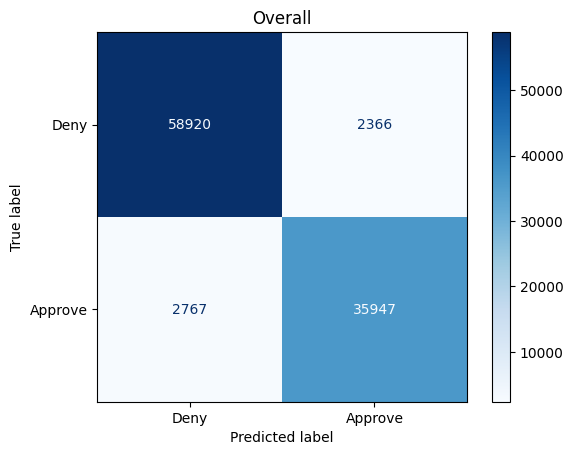

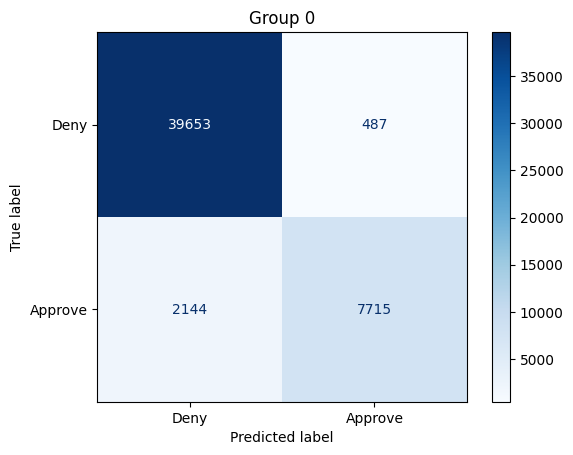

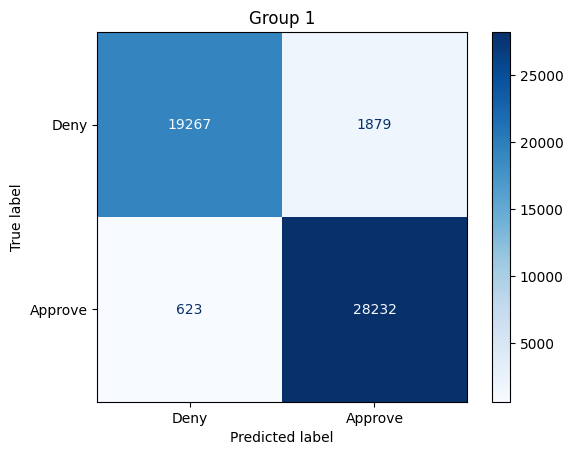

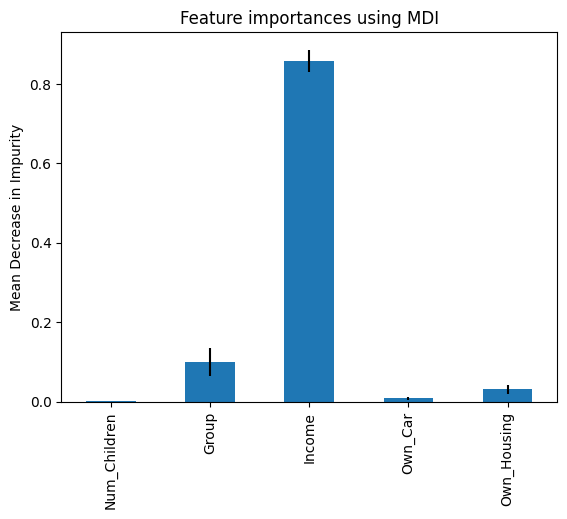

In [366]:
# metrics

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)

fairness_metrics = get_fairness_stats(X_test, y_test, model_baseline, X_test["Group"]==1, y_test_pred)
feature_importances = get_feature_importances(X_train, y_train)


<Figure size 2000x600 with 0 Axes>

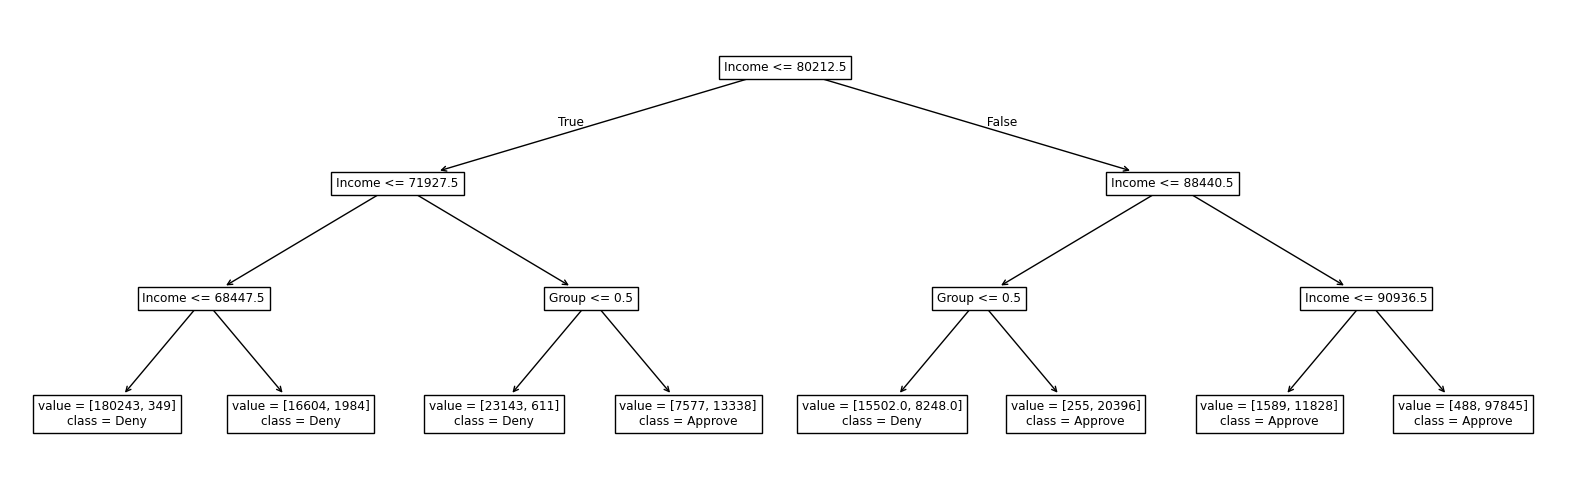

In [367]:


def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False, filename="model_visualization.jpg"):
    plt.figure(figsize=(20, 6))  # Moved inside the function to ensure a new figure is created for each call
    plot_list = plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
    [process_plot_item(item) for item in plot_list]
    plt.savefig(f"outputs/{filename}",  bbox_inches='tight')  # Save the plot as a JPEG file

def process_plot_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples"):
        item.set_text("\n".join(split_string[1:]))  # Show only the class names
    else:
        item.set_text(split_string[0])

# Example of how to call visualize_model
# model_baseline is your trained model and X_train.columns are the feature names

plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_baseline, feature_names=X_train.columns)

In [368]:
# gender unaware model

# remove gender
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# train
model_unaware = DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# predict
y_train_unaware_pred = model_unaware.predict(X_train_unaware)
y_test_unaware_pred = model_unaware.predict(X_test_unaware)

In [369]:
# prediction example
# model_unaware.predict(X_train_unaware.iloc[0:1].values).tolist()[0]

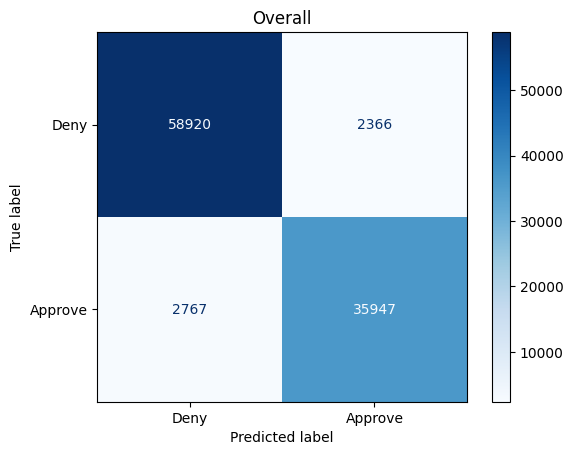

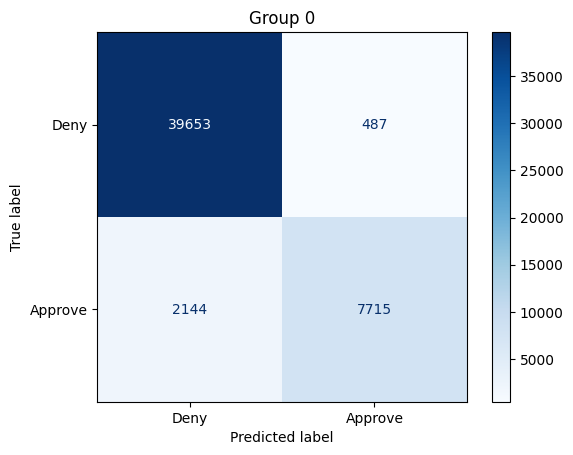

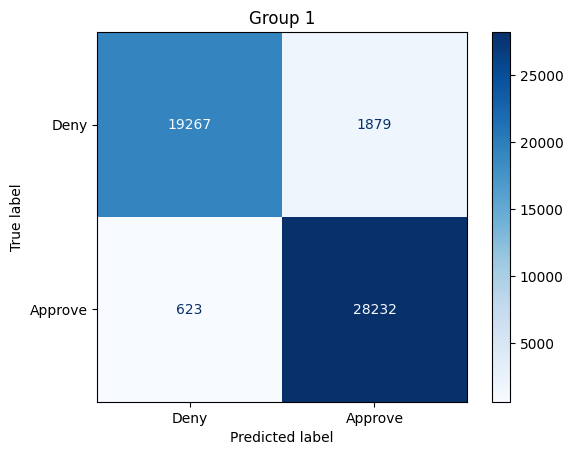

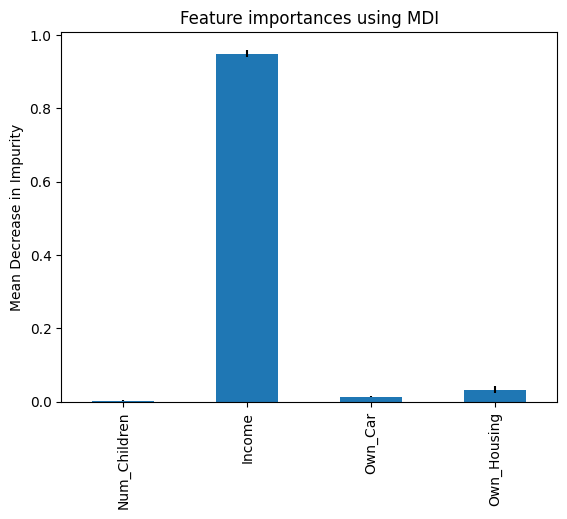

In [370]:
# metrics

train_metrics = get_metrics(y_train, y_train_unaware_pred)
test_metrics = get_metrics(y_test, y_test_unaware_pred)

fairness_metrics = get_fairness_stats(X_test, y_test, model_unaware, X_test["Group"]==1, y_test_pred)

feature_importances = get_feature_importances(X_train_unaware, y_train)

<Figure size 2000x600 with 0 Axes>

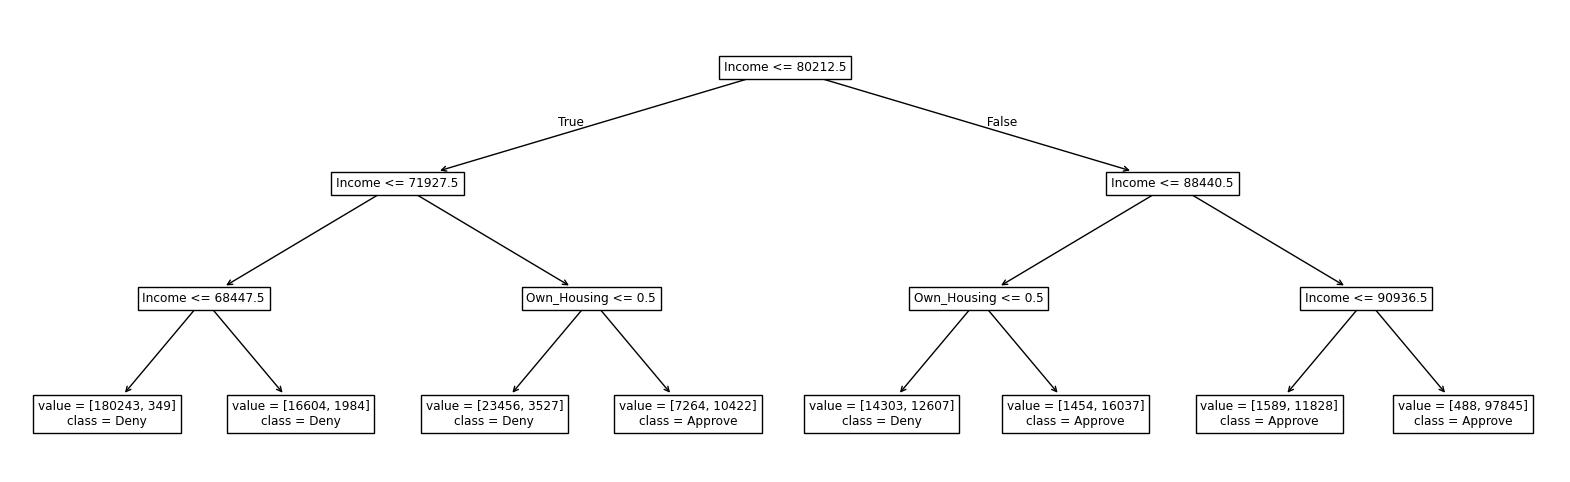

In [371]:
plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_unaware, feature_names=X_train_unaware.columns)

{'demographic_parity': {'total_number_of_approvals': 38253,
  'group_0_%': 52.03,
  'group_1_%': 47.97},
 'equal_opportunity': {'true_positive_rate': 72.86,
  'group_0_%': 100.0,
  'group_1_%': 63.59},
 'equal_accuracy': {'overall_accuracy': 79.45,
  'group_0_%': 79.91,
  'group_1_%': 78.99},
 'confusion_matrix': {'overall_confusion_matrix': [[51241, 10045],
   [10506, 28208]],
  'group_0': [[30095, 10045], [0, 9859]],
  'group_1': [[21146, 0], [10506, 18349]]}}

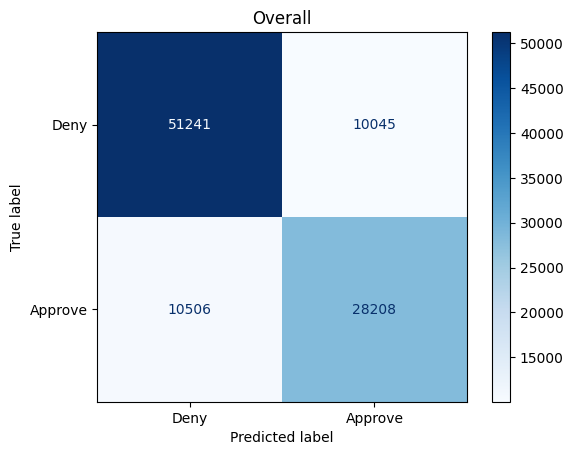

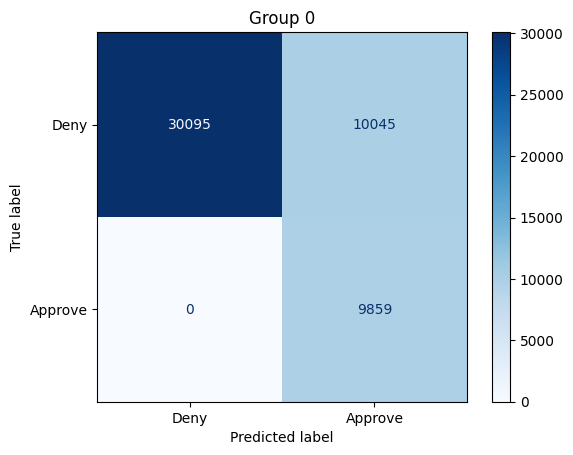

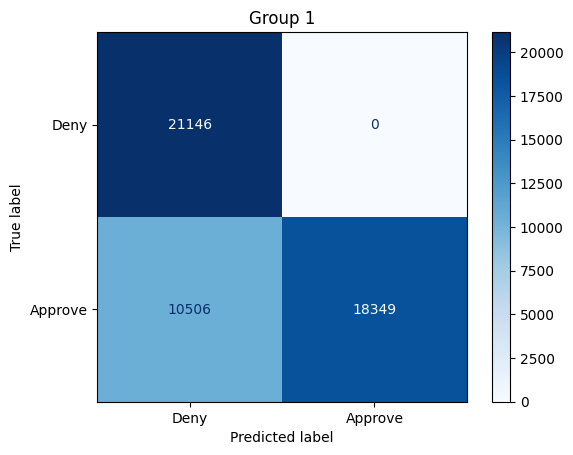

In [372]:
# threshold finetuning to further mitigate bias

zero_threshold = 0.11
one_threshold = 0.99

# predict
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs > zero_threshold) * 1) * [X_test["Group"] == 0] + ((test_probs > one_threshold) * 1) * [X_test["Group"] == 1])[0]
get_fairness_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)

# save 

In [373]:
feature_importances

'{"Num_Children":0.0034431978,"Income":0.9490834356,"Own_Car":0.0140779294,"Own_Housing":0.0333954371}'

In [374]:
# save selected model and metrics
selected_model = model_unaware
selected_model_metrics = {'train': train_metrics,
                          'test': test_metrics,
                          'fairness': fairness_metrics,
                          'feature_importances': feature_importances}

joblib.dump(selected_model, selected_model_file_path)
joblib.dump(selected_model_metrics, selected_model_metrics_file_path)

['outputs/selected_model_metrics.joblib']

In [375]:
# Write the dictionary to a file in JSON format
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

with open(selected_model_metrics_file_path.replace('joblib','json'), 'w') as file:
    json.dump(selected_model_metrics, file,  cls=NumpyEncoder, indent=4)

# track

In [376]:
# track experiment 
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

mlflow.start_run()

mlflow.log_params(
    {
        "model_type": model_name,
        "n_features": X.shape[1],
        "feature_importances": feature_importances
    }
)

for split in ["train", "test"]:
    for metric, value in selected_model_metrics[split].items():
        if metric != "confusion_matrix":  # Skip confusion_matrix as it is not a scalar metric
            mlflow.log_metric(f"{split}_{metric}", value)

mlflow.log_artifact(f"{selected_model_file_path}")

mlflow.end_run()

🏃 View run dazzling-snipe-59 at: https://mlflow.sandbox.harness-demo.site/#/experiments/663009785562031444/runs/83a61a2d4eb64a5bbeeaa4d13c38570e
🧪 View experiment at: https://mlflow.sandbox.harness-demo.site/#/experiments/663009785562031444


# test

In [377]:
# NBVAL_CHECK_OUTPUT
selected_model_metrics = joblib.load(selected_model_metrics_file_path)

In [378]:
# NBVAL_CHECK_OUTPUT
# model accuracy
threshold_accuracy = 0.8
accuracy = selected_model_metrics['test']['accuracy']
assert accuracy > threshold_accuracy, 'accuracy {} is below {}'.format(accuracy, threshold_accuracy)

In [379]:
# NBVAL_CHECK_OUTPUT
# fairness
equal_opportunity_fairness_threshold_percent = 21
equal_opportunity_group_0_percent = selected_model_metrics['fairness']['equal_opportunity']['group_0_%']
equal_opportunity_group_1_percent = selected_model_metrics['fairness']['equal_opportunity']['group_1_%']
assert abs(equal_opportunity_group_0_percent - equal_opportunity_group_1_percent) < equal_opportunity_fairness_threshold_percent, 'difference exceeds {}%'.format(equal_opportunity_fairness_threshold_percent)

In [380]:
data = selected_model_metrics

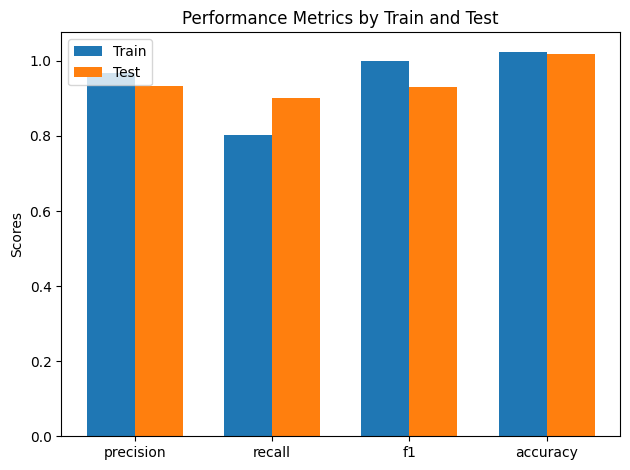

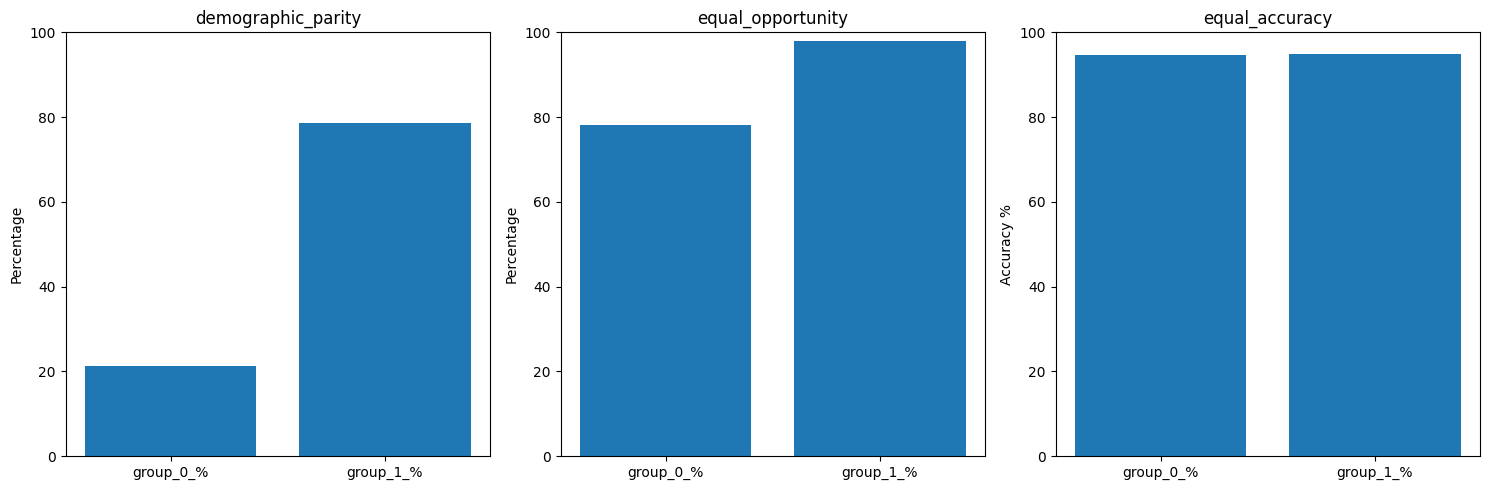

In [381]:
# Performance Metrics Visualization
performance_metrics = ['precision', 'recall', 'f1', 'accuracy']
train_performance = [data['train'][metric] for metric in performance_metrics]
test_performance = [data['test'][metric] for metric in performance_metrics]

ind = np.arange(len(performance_metrics))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train_performance, width, label='Train')
rects2 = ax.bar(ind + width/2, test_performance, width, label='Test')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Train and Test')
ax.set_xticks(ind)
ax.set_xticklabels(performance_metrics)
ax.legend()

fig.tight_layout()
plt.savefig("outputs/performance_metrics_by_train_and_test.jpg",  bbox_inches='tight')  # Save plot as JPEG file

plt.show()

# Fairness Metrics Visualization - Demographic Parity and Equal Opportunity
fairness_metrics = ['demographic_parity', 'equal_opportunity', 'equal_accuracy']
groups = ['group_0_%', 'group_1_%']
fairness_values = {metric: [data['fairness'][metric][group] for group in groups] for metric in fairness_metrics}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, (metric, values) in zip(axs, fairness_values.items()):
    ax.bar(groups, values)
    ax.set_title(metric)
    ax.set_ylabel('Percentage' if metric != 'equal_accuracy' else 'Accuracy %')
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig("outputs/fairness_metrics_visualization.jpg",  bbox_inches='tight')  # Save plot as JPEG file

plt.show()
